# Analisi econometrica e statistica del PUN con Python

Introduzione all’articolo
Breve descrizione del PUN: cos'è, chi lo stabilisce, perché è rilevante.

Obiettivo dell’articolo: analisi descrittiva + modelli econometrici di base + eventuali previsioni.

<strong>2. Caricamento e preparazione dei dati</strong>
- Parsing del file Excel in Python con pandas.
- Pulizia dei dati (gestione dei valori nulli, normalizzazione timestamp, ecc.).

<strong>3. Analisi descrittiva</strong>
- Statistiche riassuntive (media, mediana, varianza, ecc.).
- Grafici: serie temporale, istogramma, boxplot per ora/giorno/settimana.
- Analisi di stagionalità (es. differenze giorno/notte, feriali/festivi).

<strong>4. Analisi econometrica</strong>
- Test di stazionarietà (Dickey-Fuller).
- Differenziazione se necessario.
- Autocorrelazione (ACF/PACF).
- Modello ARIMA o SARIMA per modellare la serie.
- Eventuale previsione su periodo successivo.

<strong>5. Visualizzazioni avanzate</strong>
- Heatmap oraria (giorni vs ore).
- Calendar plot (per identificare anomalie stagionali o picchi).

<strong>6. Conclusioni</strong>
- Riassunto dei risultati principali.
- Interpretazione economica delle dinamiche del prezzo.

<strong>Data sources</strong>\
[Esiti MGP GME](https://www.mercatoelettrico.org/it-it/Home/Esiti/Elettricita/MGP/Esiti/PUN)

## Data preparation, descriptive statitistics and data visualization

                          Data  Ora  Prezzo
Timestamp                                  
2024-01-01 00:00:00 2024-01-01    0  107.09
2024-01-01 01:00:00 2024-01-01    1  104.00
2024-01-01 02:00:00 2024-01-01    2  100.00
2024-01-01 03:00:00 2024-01-01    3   85.66
2024-01-01 04:00:00 2024-01-01    4   85.00
count    8783.000000
mean      108.523527
std        29.658537
min         0.100000
25%        92.041590
50%       105.824370
75%       122.040000
max       275.123710
Name: Prezzo, dtype: float64


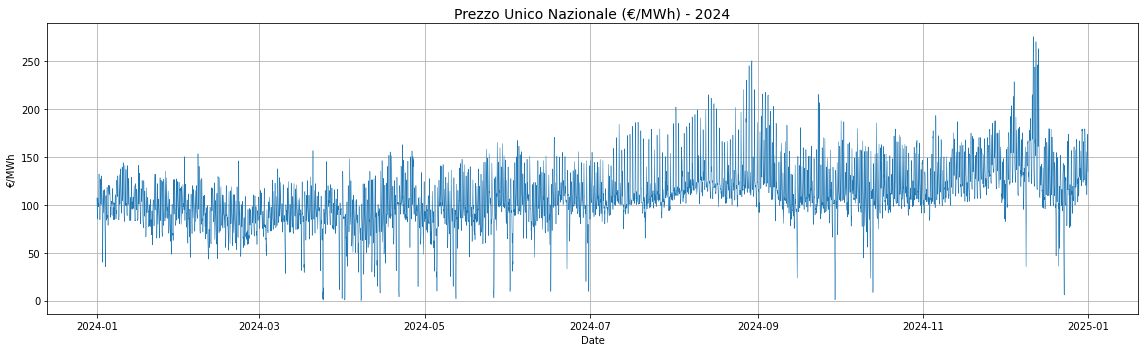

In [15]:
# --- 1. Libraries ---
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import timedelta

# --- 2. Load the Excel file ---
# Replace with your actual filename
df = pd.read_excel('20240101_20241231_PUN.xlsx')

# --- 3. Rename and parse columns ---
df.columns = ['Data', 'Ora', 'Prezzo']

# Convert 'Data' to datetime
df['Data'] = pd.to_datetime(df['Data'], dayfirst=True)

# Convert 'Ora' from 1–24 to 0–23 (Python datetime uses 0–23)
df['Ora'] = df['Ora'] - 1

# Create a full timestamp
df['Timestamp'] = df['Data'] + pd.to_timedelta(df['Ora'], unit='h')
df.set_index('Timestamp', inplace=True)

# --- 4. Convert 'Prezzo' to float ---
# Handle comma as decimal separator
df['Prezzo'] = df['Prezzo'].astype(str).str.replace(',', '.').astype(float)

# --- 5. Preview the data ---
print(df.head())

# --- 6. Descriptive statistics ---
print(df['Prezzo'].describe())

# --- 7. Time series plot ---
plt.figure(figsize=(16, 5))
plt.plot(df.index, df['Prezzo'], linewidth=0.5)
plt.title('Prezzo Unico Nazionale (€/MWh) - 2024', fontsize=14)
plt.xlabel('Date')
plt.ylabel('€/MWh')
plt.grid(True)
plt.tight_layout()
plt.show()

<strong>Add derived time features</strong>

In [16]:
# Add useful time-based features
df['Hour'] = df.index.hour
df['Day'] = df.index.day
df['Weekday'] = df.index.weekday  # Monday=0, Sunday=6
df['Month'] = df.index.month
df['Date'] = df.index.date  # useful for grouping by day

<strong>Histogram of prices</strong>

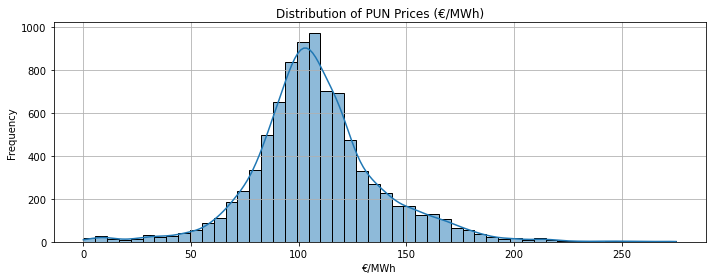

In [17]:
plt.figure(figsize=(10, 4))
sns.histplot(df['Prezzo'], bins=50, kde=True)
plt.title('Distribution of PUN Prices (€/MWh)')
plt.xlabel('€/MWh')
plt.ylabel('Frequency')
plt.grid(True)
plt.tight_layout()
plt.show()

<strong>Boxplot by hour of day</strong>

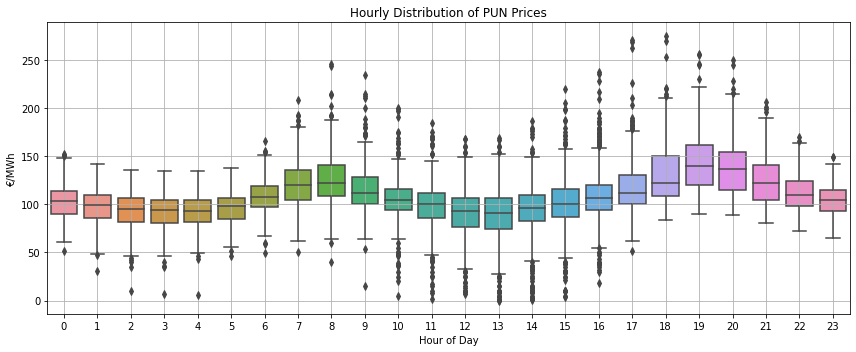

In [18]:
plt.figure(figsize=(12, 5))
sns.boxplot(data=df, x='Hour', y='Prezzo')
plt.title('Hourly Distribution of PUN Prices')
plt.xlabel('Hour of Day')
plt.ylabel('€/MWh')
plt.grid(True)
plt.tight_layout()
plt.show()

<strong>Boxplot by day of week</strong>

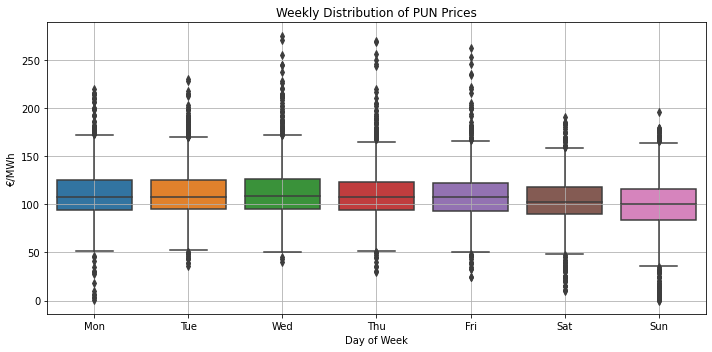

In [19]:
# Weekday labels for clarity
weekday_labels = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']

plt.figure(figsize=(10, 5))
sns.boxplot(data=df, x='Weekday', y='Prezzo')
plt.title('Weekly Distribution of PUN Prices')
plt.xlabel('Day of Week')
plt.ylabel('€/MWh')
plt.xticks(ticks=range(7), labels=weekday_labels)
plt.grid(True)
plt.tight_layout()
plt.show()


<strong>Daily average price over time</strong>

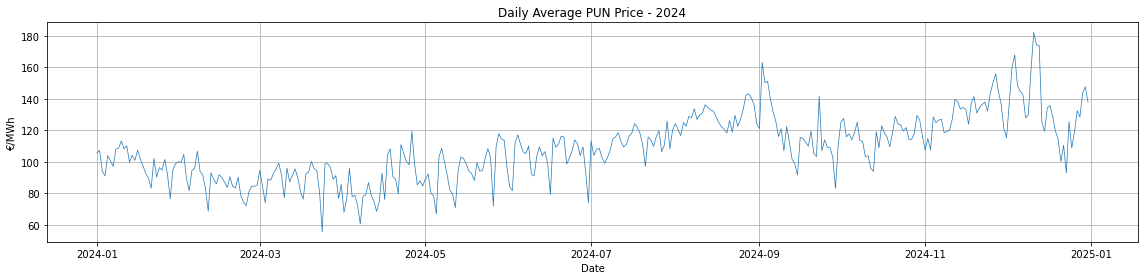

In [20]:
daily_avg = df.resample('D').mean()

plt.figure(figsize=(16, 4))
plt.plot(daily_avg.index, daily_avg['Prezzo'], linewidth=0.7)
plt.title('Daily Average PUN Price - 2024')
plt.xlabel('Date')
plt.ylabel('€/MWh')
plt.grid(True)
plt.tight_layout()
plt.show()

## Econometrics

<strong>Augmented Dickey-Fuller Test (ADF)</strong>

In [21]:
from statsmodels.tsa.stattools import adfuller

"""
Se p-value < 0.05 possiamo rifiutare l’ipotesi nulla e concludere che la serie è stazionaria.
Se p-value > 0.05, la serie non è stazionaria e necessita di trasformazioni.
"""

result = adfuller(df['Prezzo'])

print("ADF Statistic: {:.4f}".format(result[0]))
print("p-value: {:.4f}".format(result[1]))
for key, value in result[4].items():
    print(f"Critical Value ({key}): {value:.4f}")

ADF Statistic: -5.3383
p-value: 0.0000
Critical Value (1%): -3.4311
Critical Value (5%): -2.8619
Critical Value (10%): -2.5669


<strong>Differencing (se non stazionaria) </strong>

In [10]:
df['Prezzo_diff'] = df['Prezzo'].diff()
df_diff = df.dropna(subset=['Prezzo_diff'])  # remove NaNs caused by differencing

# Re-test ADF on differenced series
result_diff = adfuller(df_diff['Prezzo_diff'])

print("ADF Statistic (differenced): {:.4f}".format(result_diff[0]))
print("p-value (differenced): {:.4f}".format(result_diff[1]))

ADF Statistic (differenced): -20.2808
p-value (differenced): 0.0000


<strong>ACF & PACF plots</strong> 

<Figure size 864x288 with 0 Axes>

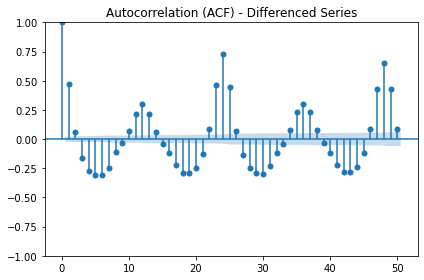

<Figure size 864x288 with 0 Axes>

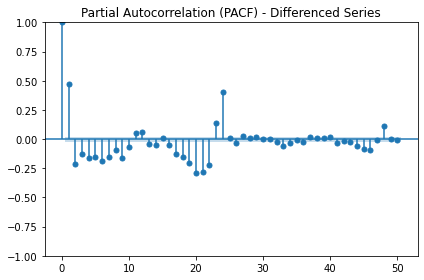

In [11]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plt.figure(figsize=(12, 4))
plot_acf(df_diff['Prezzo_diff'], lags=50)
plt.title("Autocorrelation (ACF) - Differenced Series")
plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 4))
plot_pacf(df_diff['Prezzo_diff'], lags=50)
plt.title("Partial Autocorrelation (PACF) - Differenced Series")
plt.tight_layout()
plt.show()

## Econometric Modeling - SARIMA

Passiamo alla modellazione con SARIMA, che ci consente di catturare la stagionalità giornaliera, settimanale o mensile.<br> Nel caso del PUN orario, la stagionalità giornaliera (24 ore) e settimanale (168 ore) sono particolarmente rilevanti.

In [12]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error

In [24]:
# Drop NaNs from differencing (if any)
daily_data = df['Prezzo'].resample('D').mean()
daily_data = daily_data.asfreq('D') # daily average
daily_data = daily_data.fillna(method='ffill')  # safety fill if any missing

subset = daily_data['2024-01-01':'2024-03-31']

# Fit a SARIMA model
model = SARIMAX(
    subset,
    order=(1, 1, 1),             # p, d, q
    seasonal_order=(1, 1, 1, 7), # P, D, Q, S (weekly seasonality)
    enforce_stationarity=False,
    enforce_invertibility=False
)

results = model.fit(disp=False)
print(results.summary())

                                     SARIMAX Results                                     
Dep. Variable:                            Prezzo   No. Observations:                   91
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 7)   Log Likelihood                -246.254
Date:                           Tue, 25 Mar 2025   AIC                            502.508
Time:                                   14:27:58   BIC                            514.028
Sample:                               01-01-2024   HQIC                           507.104
                                    - 03-31-2024                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1704      0.156      1.091      0.275      -0.136       0.476
ma.L1         -0.7659      0.141     -5.416

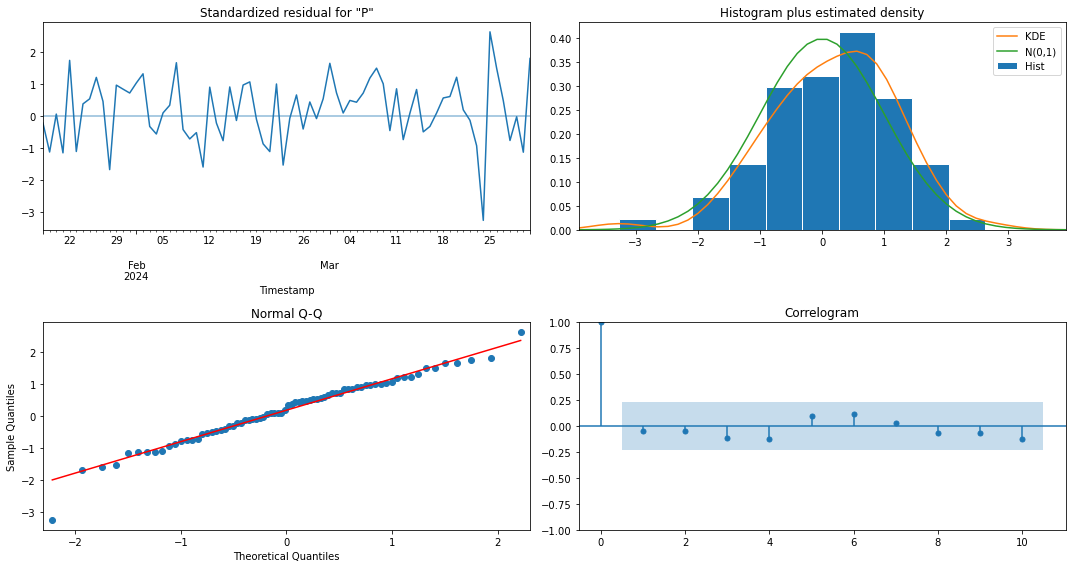

In [25]:
results.plot_diagnostics(figsize=(15, 8))
plt.tight_layout()
plt.show()

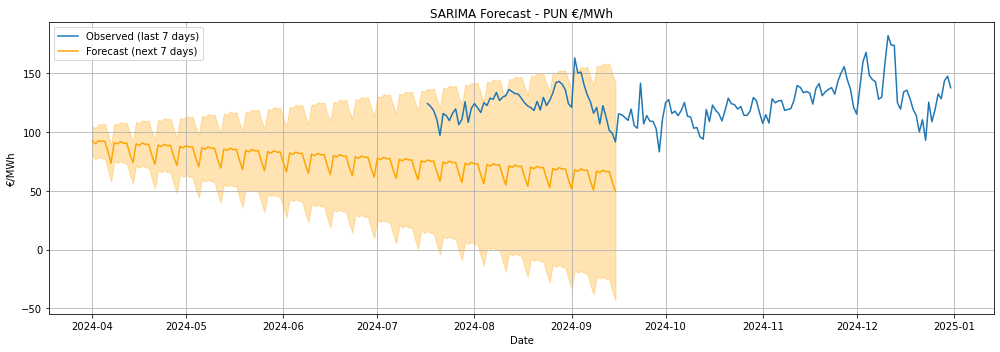

In [27]:
forecast = results.get_forecast(steps=168)
forecast_df = forecast.summary_frame()

# Plot
plt.figure(figsize=(14, 5))
plt.plot(daily_data[-168:], label='Observed (last 7 days)')
plt.plot(forecast_df['mean'], label='Forecast (next 7 days)', color='orange')
plt.fill_between(forecast_df.index,
                 forecast_df['mean_ci_lower'],
                 forecast_df['mean_ci_upper'],
                 color='orange', alpha=0.3)
plt.title('SARIMA Forecast - PUN €/MWh')
plt.xlabel('Date')
plt.ylabel('€/MWh')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

## Heatmap on hourly prices

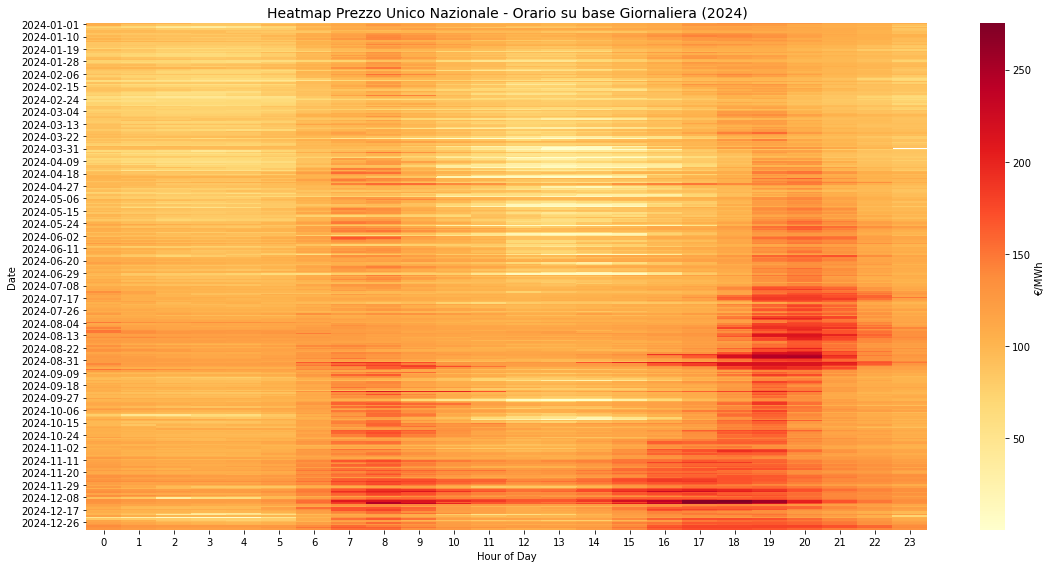

In [28]:
import matplotlib.dates as mdates

# 1. Riorganizza i dati: pivot con giorni sulle righe, ore sulle colonne
heatmap_data = df.copy()
heatmap_data['Date'] = heatmap_data.index.date
heatmap_data['Hour'] = heatmap_data.index.hour

pivot = heatmap_data.pivot_table(index='Date', columns='Hour', values='Prezzo')

# 2. Plot della heatmap
plt.figure(figsize=(16, 8))
sns.heatmap(pivot, cmap='YlOrRd', cbar_kws={'label': '€/MWh'})
plt.title('Heatmap Prezzo Unico Nazionale - Orario su base Giornaliera (2024)', fontsize=14)
plt.xlabel('Hour of Day')
plt.ylabel('Date')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()